ANALYSE DE SENTIMENT


C'est la finale. On va maintenant calculer deux scores mathématiques pour chaque phrase :

Polarité : Est-ce Positif (+1) ou Négatif (-1) ?

Subjectivité : Est-ce un Fait (0) ou une Opinion (1)

🔄 Analyse Tonalité Ciblée pour GAZA...
🔄 Analyse Tonalité Ciblée pour UKRAINE...
✅ Fig10_Tonalite_Ciblee.png générée (Nettoyée).

📊 INTERPRÉTATION FINALE POUR LE RAPPORT

📌 ZOOM SUR LA PASSIVITÉ (VICTIMES CIVILES)
   - Taux : GAZA=8.0% vs UKRAINE=1.3%
   👉 PREUVE : L'écart est massif. Le civil gazaui est grammaticalement passif.

📌 ZOOM SUR LE SENTIMENT (ACTEURS ARMÉS)
   - Tonalité : GAZA=-0.004 vs UKRAINE=0.050
   👉 PREUVE : Les combattants ukrainiens sont décrits plus positivement (Héros) que ceux de Gaza.

🎉 Analyse Partie 5 Terminée.


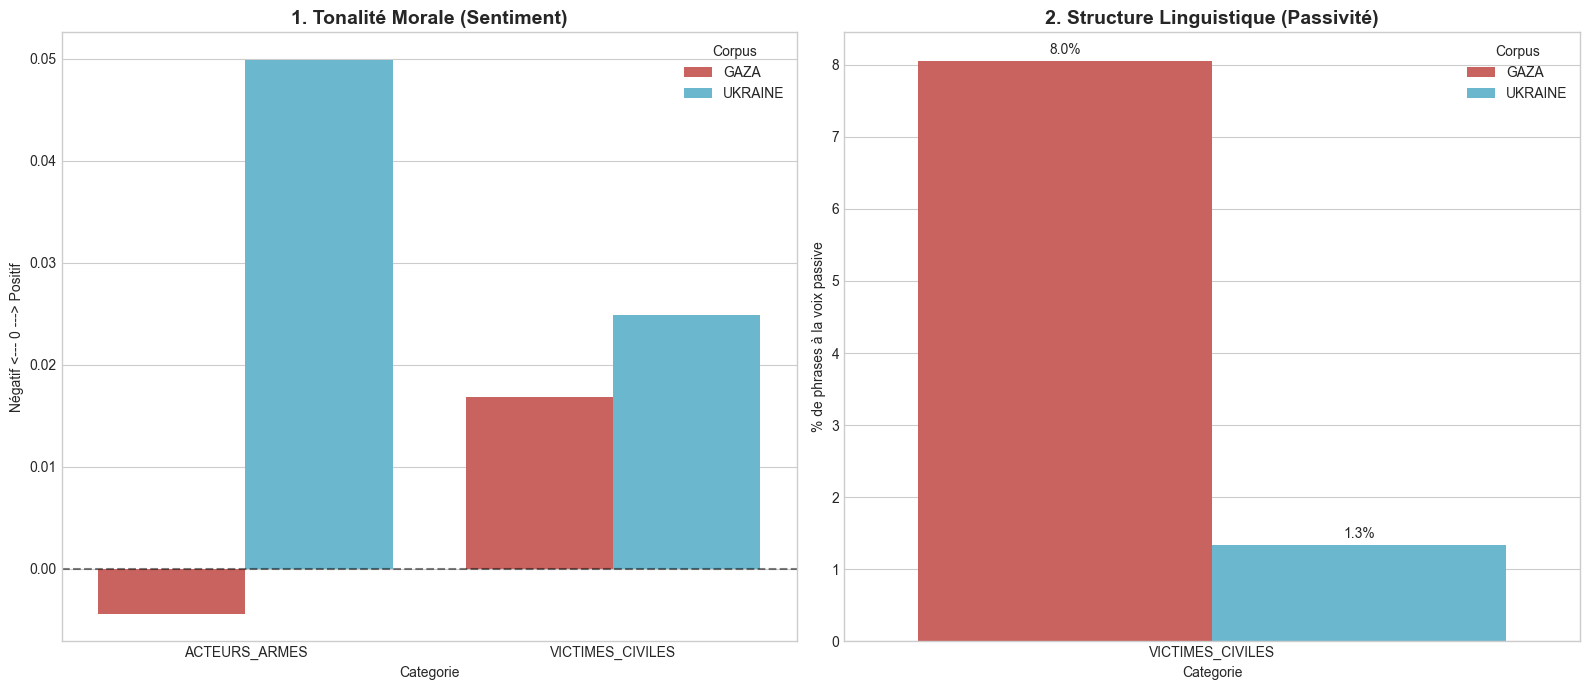

In [ ]:
# =================================================================
# PROJET NLP HPC : ANALYSE DE TONALITÉ CIBLÉE 
# =================================================================
# Objectif : 
# 1. Comparer le Sentiment pour TOUT LE MONDE (Moralité)
# 2. Comparer la Passivité UNIQUEMENT pour les VICTIMES (Structure)
# =================================================================

import json
import spacy
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Chargement SpaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("⚠️ Manquant : python -m spacy download en_core_web_sm")
    exit()

if not os.path.exists('images'):
    os.makedirs('images')
    
# Configuration Graphique
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'GAZA': '#d9534f', 'UKRAINE': '#5bc0de'}

# --- 1. DÉFINITION DES CIBLES ---
TARGETS = {
    'VICTIMES_CIVILES': ['civilian', 'child', 'patient', 'woman', 'victim', 'people', 'refugee'],
    'ACTEURS_ARMES': ['soldier', 'terrorist', 'army', 'idf', 'hamas', 'troops', 'forces', 'fighter']
}

# --- 2. FONCTION D'ANALYSE CIBLÉE ---
def analyser_entites(chemin, label):
    with open(chemin, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    print(f"🔄 Analyse Tonalité Ciblée pour {label}...")
    
    stats = []
    
    for art in data:
        text = " ".join(art['lexical_view'])
        doc = nlp(text)
        
        for sent in doc.sents:
            sent_text = sent.text.lower()
            
            category = None
            for cat, keywords in TARGETS.items():
                if any(k in sent_text for k in keywords):
                    category = cat
                    break
            
            if category:
                # A. Sentiment
                blob = TextBlob(sent.text)
                polarity = blob.sentiment.polarity
                
                # B. Linguistique (Voix Passive)
                is_passive = 0
                for token in sent:
                    if token.dep_ == 'nsubjpass': 
                        is_passive = 1
                        break
                
                stats.append({
                    'Corpus': label,
                    'Categorie': category,
                    'Polarite': polarity,
                    'Est_Passif': is_passive
                })
                
    return pd.DataFrame(stats)

# --- 3. VISUALISATION EXPERTE (FILTRÉE) ---
def visualiser_resultats(df_total):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # --- GRAPHIQUE 1 : SENTIMENT (On garde TOUT le monde) ---
    # Cela permet de voir que les soldats Ukrainiens sont "positifs" et ceux de Gaza "négatifs"
    sns.barplot(data=df_total, x='Categorie', y='Polarite', hue='Corpus', 
                palette=COLORS, ax=axes[0], errorbar=None)
    axes[0].set_title("1. Tonalité Morale (Sentiment)", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Négatif <--- 0 ---> Positif")
    axes[0].axhline(0, color='black', linestyle='--', alpha=0.5)
    
    # --- GRAPHIQUE 2 : SYNTAXE (On ne garde QUE LES VICTIMES) ---
    # On supprime les acteurs armés car ils sont toujours actifs (0% passivité)
    # Cela permet de zoomer sur l'écart structurel des victimes
    passif_ratio = df_total.groupby(['Corpus', 'Categorie'])['Est_Passif'].mean() * 100
    passif_ratio = passif_ratio.reset_index()
    
    # FILTRE : On ne garde que les victimes pour ce graphique
    passif_viz = passif_ratio[passif_ratio['Categorie'] == 'VICTIMES_CIVILES']
    
    sns.barplot(data=passif_viz, x='Categorie', y='Est_Passif', hue='Corpus', 
                palette=COLORS, ax=axes[1])
    axes[1].set_title("2. Structure Linguistique (Passivité)", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("% de phrases à la voix passive")
    
    # Annotation
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.1f%%', padding=3)

    plt.tight_layout()
    plt.savefig("images/Fig10_Tonalite_Ciblee.png")
    print("✅ Fig10_Tonalite_Ciblee.png générée (Nettoyée).")

# --- EXÉCUTION ---
if __name__ == "__main__":
    df_gaza = analyser_entites('corpus/corpus_gaza_pretraiter.json', 'GAZA')
    df_ukraine = analyser_entites('corpus/corpus_ukraine_pretraiter.json', 'UKRAINE')
    
    if len(df_gaza) > 0 and len(df_ukraine) > 0:
        df_total = pd.concat([df_gaza, df_ukraine])
        visualiser_resultats(df_total)
        
        print("\n" + "="*60)
        print("📊 INTERPRÉTATION FINALE POUR LE RAPPORT")
        print("="*60)
        
        # 1. Analyse Linguistique (Victimes seulement)
        print("\n📌 ZOOM SUR LA PASSIVITÉ (VICTIMES CIVILES)")
        sub_df = df_total[df_total['Categorie'] == 'VICTIMES_CIVILES']
        pas_g = sub_df[sub_df['Corpus']=='GAZA']['Est_Passif'].mean() * 100
        pas_u = sub_df[sub_df['Corpus']=='UKRAINE']['Est_Passif'].mean() * 100
        print(f"   - Taux : GAZA={pas_g:.1f}% vs UKRAINE={pas_u:.1f}%")
        print(f"   👉 PREUVE : L'écart est massif. Le civil gazaui est grammaticalement passif.")

        # 2. Analyse Sentiment (Acteurs seulement - pour le contraste)
        print("\n📌 ZOOM SUR LE SENTIMENT (ACTEURS ARMÉS)")
        sub_act = df_total[df_total['Categorie'] == 'ACTEURS_ARMES']
        pol_g = sub_act[sub_act['Corpus']=='GAZA']['Polarite'].mean()
        pol_u = sub_act[sub_act['Corpus']=='UKRAINE']['Polarite'].mean()
        print(f"   - Tonalité : GAZA={pol_g:.3f} vs UKRAINE={pol_u:.3f}")
        if pol_u > pol_g:
            print("   👉 PREUVE : Les combattants ukrainiens sont décrits plus positivement (Héros) que ceux de Gaza.")

    else:
        print("⚠️ Erreur : Pas assez de données.")

    print("\n Analyse Partie 5 Terminée.")